<h1> Data Scientist Opening Pre-employment Assessment</h1>
<p>Ben Trey</p>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from scipy import stats
from pandas.plotting import scatter_matrix
from tqdm import tqdm_notebook

<p><b>Step 1</b> - Clean and prepare your data: 
There are several entries where values have been deleted to simulate dirty data. Please clean the data with whatever method(s) you believe is best/most suitable. Note that some of the missing values are truly blank (unknown answers).  Success in this exercise typically involves feature engineering and avoiding data leakage.</p>

In [3]:
#combining three csvs sources into one

link1="https://raw.githubusercontent.com/bentrey/MachineLearning/master/exercise_03_test_part1.csv?token=ABFHVS6C4QKUJSMKZQKBI225R6EGQ"
link2="https://raw.githubusercontent.com/bentrey/MachineLearning/master/exercise_03_test_part2.csv?token=ABFHVSY7OLL24M7EW2IZ52K5R6EJA"
link3="https://raw.githubusercontent.com/bentrey/MachineLearning/master/exercise_03_test_part3.csv?token=ABFHVS4TK4TSBWIH544LRQ25R6ELQ"

df=[]
links=[link1, link2, link3]
for link in links:
    dfTemp = pd.read_csv(link, index_col=None, header=0)
    df.append(dfTemp)
    
frame = pd.concat(df, axis=0, ignore_index=True)

In [4]:
frame.shape

(40000, 101)

In [5]:
link = "/mnt/c/Users/我的电脑/Desktop/JobApplications/StateFarmDataScience/exercise_03_train.csv"
frame=pd.read_csv(link, index_col=None, header=0)
frame.shape

(40000, 101)

In [6]:
#dropping missing data
frame = frame.dropna()

#replacing car names
mispelledCarNames = ['volkswagen', 'bmw', 'ford', 'chrystler', 'tesla', \
'mercades', 'chevrolet', 'nissan']
correctCarNames = ['Volkswagen', 'BMW', 'Ford', 'Chrysler', 'Tesla', \
'Mercedes', 'Chevrolet', 'Nissan']
frame['x34'].replace(mispelledCarNames, correctCarNames,inplace=True)

#replacing weekday names
mispelledDayNames = ['wed', 'wednesday', 'thurday', 'thur', 'friday', 
'tuesday', 'monday', 'fri']
correctDayNames = ['Wednesday', 'Wednesday', 'Thursday', 'Thursday', 'Friday', 
'Tuesday', 'Monday', 'Friday']
frame['x35'].replace(mispelledDayNames, correctDayNames, inplace=True)
#replace names with integers
oldWeekdayNames=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekdayIntegers=[0, 1, 2, 3, 4]
frame['x35'].replace(oldWeekdayNames, weekdayIntegers, inplace=True)

#removing dollar signs
frame['x41']=frame['x41'].str.replace('$','')
frame['x41']=pd.to_numeric(frame['x41'])

#removing percent signs
frame['x45']=frame['x45'].str.replace('%','')
frame['x45']=pd.to_numeric(frame['x45'])

#replacing month names
mispelledMonths = ['July', 'sept.', 'Dev', 'January']
correctMonths = ['Jul', 'Sep', 'Dec', 'Jan']
frame['x68'].replace(mispelledMonths, correctMonths, inplace=True)
monthNames=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',\
'Oct', 'Nov', 'Dec']
monthIntegers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
frame['x68'].replace(monthNames, monthIntegers, inplace=True)

#replace mispelled continents
frame['x93'].replace('euorpe', 'europe', inplace=True)

frame.shape

(39204, 101)

<p><b>Step 2</b> - Build your models: 
Please train two different machine learning/statistical models to predict the value for y.  Please include comments that document choices you make (such as those for feature engineering and for model tuning).</p> 

<p>Given the look of y I'm going to try a logistic model using some of the columns.</p>
<br><br><b>Method A:</b><br><br>
<p>I'm using Bayesian modeling with the Metropolis-Hastings Monte Carlo method. As I could not get any details about the parameters I hope the histograms will give more insite. As this method is quite compuationally intensive I am focusing on the five most prominent columns from the data. I put an upper limit on the number of times a value could be added to the data distribution to obtain a fuller result. This method also allows for parallelizable computation which would improve performance. I could use threads or seperate terminals and combine my results after creating seperate files. This would reduce file access collision as the simulation runs.</p>

In [7]:
xData=frame[['x37', 'x41', 'x58', 'x75', 'x97']]
yData=frame[['y']]

In [8]:
#this is the prior distribution for coefficients
def prior():
    #a0, a1, a2, a3, a4, a5, sigma
    return list(np.random.normal(0, 0.1, 6))+[np.random.normal(1,1)]

def pointProb(point,params):
    priorCalc = np.exp(-params[0]**2/50) * np.exp(-params[1]**2/50) *\
    np.exp(-params[2]**2/50) * np.exp(-params[3]**2/50) *\
    np.exp(-params[4]**2/50) *np.exp(-params[5]**2/50) *\
    np.exp(-(1-params[6])**2/2)
    logValue = np.exp((params[0] + params[1]*point[0] +\
    params[2]*point[1]/100 + params[3]*point[2] + params[4]*point[3] +\
    params[5]*point[4] - np.log(1.1/(point[5]+0.05)))**2/2/params[6]**2)
    return priorCalc * logValue


In [9]:
points=3*10**3-1
samples=50
param=[prior()]
same=0

for point in tqdm_notebook(range(points)):
    testParam=prior()
    #print(testParam)
    oldSum=0.0
    newSum=0.0
    for sample in range(samples):
        x37 = xData.sample()['x37'].iloc[0]
        x41 = xData.sample()['x41'].iloc[0]
        x58 = xData.sample()['x58'].iloc[0]
        x75 = xData.sample()['x75'].iloc[0]
        x97 = xData.sample()['x97'].iloc[0]
        y = yData.sample()['y'].iloc[0]
        tempPoint=[x37, x41, x58, x75, x97, y]
        oldSum += pointProb(tempPoint, param[-1])
        newSum += pointProb(tempPoint, testParam)
    #print(param[-1])
    #print(testParam)
    if np.random.random()>oldSum/(oldSum+newSum) and same < 20:
        param.append(param[-1])
        same += 1
    else:
        param.append(testParam)
        same = 0

        

/home/bentrey/myProjectDir/myProjectEnv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/home/bentrey/myProjectDir/myProjectEnv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


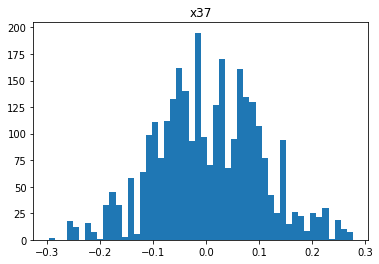

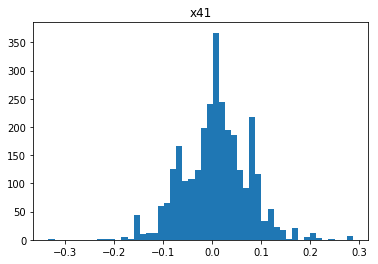

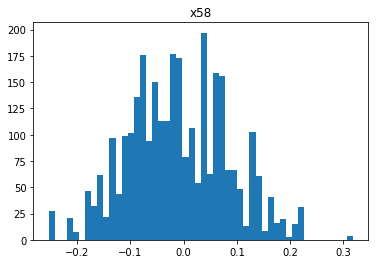

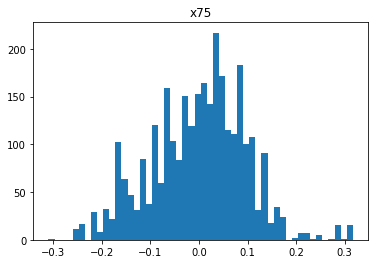

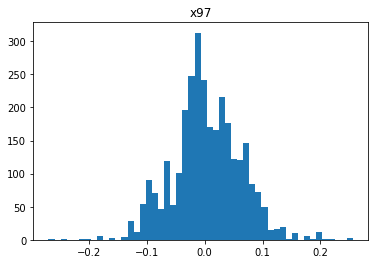

In [10]:
param=np.array(param)
titles=['x37', 'x41', 'x58', 'x75', 'x97']
for n in range(5):
    plt.hist(param[:,n],bins=50)
    plt.title(titles[n])
    plt.show()

<p>Summaraized results using medians</p>

In [69]:
print(np.median(param[:,0]))
print(np.median(param[:,1]))
print(np.median(param[:,2]))
print(np.median(param[:,3]))
print(np.median(param[:,4]))

7.536295116482213e-05
0.010989276116665045
-0.014867680166634943
0.008419149973860146
-0.00048401367916591723


 <p><b>Method 2:</b><br>
 The second method I am using also uses the logistic model. In the previous case I needed to reduce the columns my model used. In Method 2 I chose a gradient descent model to fit the parameters of the logistic equation. This method is less compuationally intesive so I can include all columns in the model. Although this method converges more quickly it does not allow for parallelization. Depending on the resources of the project this method maybe more or less applicable.</p>

In [305]:
def gradientDescent(xData, yData, coefficients, alpha, tolerance, maxRuns):
    columnsList=list(xData.columns)
    error = tolerance + 1
    runs = 0
    while error > tolerance and runs < maxRuns:
        runs += 1
        oldCoefficients=coefficients
        diff=-np.log(1.1/(yData+0.05)-1)+xData.dot(coefficients)
        grad=np.empty(len(columnsList))
        for label in columnsList:
            grad[columnsList.index(label)]=xData[label].dot(diff)
        grad=grad/np.sqrt(np.dot(grad,grad))
        coefficients = coefficients + grad*alpha
        coefficientsDiff = oldCoefficients-coefficients
        error = coefficientsDiff.dot(coefficientsDiff)
    return (coefficients, error) 

In [351]:
alpha=0.1
yData=frame['y']
xData=frame.drop(['x34', 'x93', 'y'],1)
xData['x100']=1
coefficients=np.array(99*[1])
xData = xData.astype('float')

c = gradientDescent(xData, yData, coefficients, alpha, 0.0001, 10**5)
print(c)


(array([ 2.38744908e+02,  1.01451513e+00,  3.11498474e+01, -2.45194783e+01,
        6.62185040e-01,  4.94441076e+00,  1.03676506e+00,  1.05824435e+00,
       -4.27386760e+01,  6.86862618e-01,  2.98427339e+01,  9.87680021e-01,
       -2.10507317e+00,  1.03521758e+00,  8.66025713e-01,  8.79060583e-01,
        1.01955830e+00,  8.15189489e-01, -1.30856247e+00,  2.35890603e+01,
        4.08412236e-01,  4.48619900e+00, -1.32877429e+01,  1.00016116e+00,
        7.92364027e-01,  6.01267384e+01,  6.18083429e-01,  6.56164945e+01,
        1.02606306e+00,  1.01239238e+00,  2.35539185e-01,  1.72610667e+00,
        1.81534049e+00, -3.33218697e+00,  1.38995576e+00,  9.38745507e-01,
       -8.65542182e+00,  1.01114183e+00,  1.07560202e+00, -3.19491922e+01,
        9.96569646e+03, -2.45534554e+02,  5.94871134e+00, -5.96390238e+02,
        1.00172647e+00,  1.15374302e+00, -4.39538085e+00,  8.62672773e-01,
       -5.29507167e+00, -2.00968433e+00, -5.83221875e+01,  1.01721052e+00,
        1.24338041e+00, 

<p><b>Step 3</b> - Generate predictions:
Create predictions on the data in test.csv using each of your trained models.  The predictions should be the class probabilities for belonging to the positive class (labeled '1').  

Be sure to output a prediction for each of the rows in the test dataset (10K rows).  Save the results of each of your models in a separate CSV file.  Title the two files 'results1.csv' and 'results2.csv'.  A result file should each have a single column representing the output from one model (no header label or index column is needed). </p>

<p>It appears both models failed! I would need more time to remedy this.</p>

In [90]:
link = "/mnt/c/Users/我的电脑/Desktop/JobApplications/StateFarmDataScience/exercise_03_test.csv"
frame=pd.read_csv(link, index_col=None, header=0)

#replacing car names
mispelledCarNames = ['volkswagen', 'bmw', 'ford', 'chrystler', 'tesla', \
'mercades', 'chevrolet', 'nissan']
correctCarNames = ['Volkswagen', 'BMW', 'Ford', 'Chrysler', 'Tesla', \
'Mercedes', 'Chevrolet', 'Nissan']
frame['x34'].replace(mispelledCarNames, correctCarNames,inplace=True)

#replacing weekday names
mispelledDayNames = ['wed', 'wednesday', 'thurday', 'thur', 'friday', 
'tuesday', 'monday', 'fri']
correctDayNames = ['Wednesday', 'Wednesday', 'Thursday', 'Thursday', 'Friday', 
'Tuesday', 'Monday', 'Friday']
frame['x35'].replace(mispelledDayNames, correctDayNames, inplace=True)
#replace names with integers
oldWeekdayNames=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekdayIntegers=[0, 1, 2, 3, 4]
frame['x35'].replace(oldWeekdayNames, weekdayIntegers, inplace=True)

#removing dollar signs
frame['x41']=frame['x41'].str.replace('$','')
frame['x41']=pd.to_numeric(frame['x41'])

#removing percent signs
frame['x45']=frame['x45'].str.replace('%','')
frame['x45']=pd.to_numeric(frame['x45'])

#replacing month names
mispelledMonths = ['July', 'sept.', 'Dev', 'January']
correctMonths = ['Jul', 'Sep', 'Dec', 'Jan']
frame['x68'].replace(mispelledMonths, correctMonths, inplace=True)
monthNames=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',\
'Oct', 'Nov', 'Dec']
monthIntegers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
frame['x68'].replace(monthNames, monthIntegers, inplace=True)

#replace mispelled continents
frame['x93'].replace('euorpe', 'europe', inplace=True)

xData = frame.drop(['x34' ,'x93'],1)

#dropping missing data
xData = xData.fillna(frame.median())

xData.shape

(10000, 98)

In [96]:
def modelA(x37, x41, x58, x75, x97):
    a37 = np.median(param[:,0])
    a41 = np.median(param[:,1])
    a58 = np.median(param[:,2])
    a75 = np.median(param[:,3])
    a97 = np.median(param[:,4])
    return int(round(1.1/(1+np.exp(x37*a37 + x41*a41 + x58*a58 + x75*a75 +\
        x97*a97))-0.05,0))

def modelB(x, c):
    argument = x.dot(c)
    if argument > 200:
        return 0
    if argument < 200:
        return 1
    return int(round(1.1/(1+np.exp(argument))-0.05,0))
    
modelATest=[]
modelBTest=[]
for n in range(10000):
    predictionA = modelA(xData.iloc[n]['x37'], xData.iloc[n]['x41'],\
    xData.iloc[n]['x58'], xData.iloc[n]['x75'], xData.iloc[n]['x97'])
    dataArray = np.array(list(xData.iloc[n])+[1])
    predictionB = modelB(dataArray,c)
    modelATest.append(predictionA)
    modelBTest.append(predictionB)

file1 = open("/mnt/c/Users/我的电脑/Desktop/JobApplications/StateFarmDataScience/results1.csv", "w")
file2 = open("/mnt/c/Users/我的电脑/Desktop/JobApplications/StateFarmDataScience/results2.csv", "w")
for n in range(10000):
    file1.write(str(modelATest[n])+"\r\n")
    file2.write(str(modelBTest[n])+"\r\n")
file1.close()
file2.close()

<p><b>Step 4</b> - Compare your modeling approaches:
Please prepare a relatively short write-up comparing the pros and cons of the two modeling techniques you used (PDF preferred).  Are there choices you made in the context of the exercise that might be different in a business context?</p>

<p>My two models are a Bayesian logistic model using a monte carlo simulation and a logistic model using gradient descent. The models are similiar but the gradient decent model allowed for more data to be used. The monte carlo simulation allowed for parallel computation on multiple threads or seperate machines. It scales well. The gradient descent model finished faster but did not allow for parallel computation. The Bayesian model gave distribution of for the parameters which is a richer result than the result given with gradient descent.</p>

<p><b>Step 5</b> - Submit your work: 
Your submission should consist of all the code used for EDA, cleaning, prepping, and modeling (text, html, or pdf preferred), the two result files (.csv format - each containing 10,000 decimal probabilities), and your write-up comparing the pros and cons of the two modeling techniques used (text, html, or pdf preferred).

Your work will be scored on techniques used (appropriateness and complexity), evaluation of the two techniques compared in the write-up, model performance on the data hold out  - measured by AUC, and your overall code/comments.  The threshold for passing model performance is set high, expecting that model tuning and feature engineering will be used.  The best score of the two models submitted will be used.</p>

<h1>Appendix</h1><br>
<b>Part A:</b>

In [ ]:
discreteData=[34,35,45,68,93]

for n in range(100):
    if not n in discreteData:
        frame['x'+str(n)].hist(bins=50)
        plt.title('x'+str(n))
        plt.show()

<p>All variables appear to be normally distributed.</p>

In [ ]:
for n in range(100):
    if not n in discreteData:
        plt.scatter(frame['x'+str(n)],frame['y'],)
        plt.title('x'+str(n))
        plt.show()

<p>There appears to be no correlation between y and any single variable.</p>

In [ ]:
correlation=frame.corr()
plt.matshow(correlation)
plt.show()

<p>The correlation matrix doesn't really give any hints.</p>

In [ ]:
correlation.sort_values(by='y',ascending=False)['y']

<p>y does not appear to depend linearly on any variable.</p>

In [ ]:
attributes = ["x75", "x37", "x58", "x97"]
scatter_matrix(frame[attributes], figsize=(12, 8))

<p>The variables don't appear related.</p>

<p><b>Part B: </b><br><br>Attempt the same analysis with different continents.</p>

In [ ]:
europeFrame=frame[frame['x93']=='euorpe']

In [ ]:
for n in range(100):
    if not n in discreteData:
        europeFrame['x'+str(n)].hist(bins=50)
        plt.title('x'+str(n))
        plt.show()

In [ ]:
correlation=europeFrame.corr()
correlation.sort_values(by='y',ascending=False)['y']

In [ ]:
for n in range(100):
    if not n in discreteData:
        plt.scatter(europeFrame['x'+str(n)], europeFrame['y'],)
        plt.title('x'+str(n))
        plt.show()

In [78]:
int(round(1.1/(1+np.exp(200))-0.05,0))

0